In [1]:
from google.colab import drive

drive.mount("/content/C")

Mounted at /content/C


In [2]:
!unzip /content/C/MyDrive/CS419-IR/Cranfield.zip -d Cranfield

Archive:  /content/C/MyDrive/CS419-IR/Cranfield.zip
   creating: Cranfield/Cranfield/
  inflating: Cranfield/Cranfield/1.txt  
  inflating: Cranfield/Cranfield/10.txt  
  inflating: Cranfield/Cranfield/100.txt  
  inflating: Cranfield/Cranfield/1000.txt  
  inflating: Cranfield/Cranfield/1001.txt  
  inflating: Cranfield/Cranfield/1002.txt  
  inflating: Cranfield/Cranfield/1003.txt  
  inflating: Cranfield/Cranfield/1004.txt  
  inflating: Cranfield/Cranfield/1005.txt  
  inflating: Cranfield/Cranfield/1006.txt  
  inflating: Cranfield/Cranfield/1007.txt  
  inflating: Cranfield/Cranfield/1008.txt  
  inflating: Cranfield/Cranfield/1009.txt  
  inflating: Cranfield/Cranfield/101.txt  
  inflating: Cranfield/Cranfield/1010.txt  
  inflating: Cranfield/Cranfield/1011.txt  
  inflating: Cranfield/Cranfield/1012.txt  
  inflating: Cranfield/Cranfield/1013.txt  
  inflating: Cranfield/Cranfield/1014.txt  
  inflating: Cranfield/Cranfield/1015.txt  
  inflating: Cranfield/Cranfield/1016.txt

In [9]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from numpy.linalg import norm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from collections import Counter,defaultdict

from tqdm import tqdm
import json
import re
import os
import math
import numpy as np
import pandas as pd
import operator
from matplotlib import pyplot as plt

from collections import OrderedDict

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
path = "/content/Cranfield/Cranfield"
path_query = "/content/Cranfield/TEST/query.txt"
path_res = "/content/Cranfield/TEST/RES/{}.txt"

In [10]:
# Read cranfield dataset (documents)
print("Đang đọc tài liệu Cranfield...")
documents = []
for i in tqdm(range(1, 1401), desc="Đọc tài liệu"):
    file_name = f"{i}.txt"
    path_file_name = os.path.join(path, file_name)
    with open(path_file_name, 'r', encoding='UTF-8') as file:
      documents.append(file.read())

Đang đọc tài liệu Cranfield...


Đọc tài liệu: 100%|██████████| 1400/1400 [00:00<00:00, 30918.42it/s]


In [11]:
# Read query file
raw_queries = []
with open(path_query, 'r', encoding='UTF-8') as f:
    for _ in tqdm(range(1, 226), desc="Đọc truy vấn"):
        line = f.readline()
        if not line:
            break
        raw_queries.append(line.strip())


Đọc truy vấn: 100%|██████████| 225/225 [00:00<00:00, 305905.48it/s]


In [12]:
# Read relevant documents (RES)
RES = []
for index in tqdm(range(1, 226), desc="Đọc RES"):
  with open(path_res.format(index), 'r', encoding='UTF-8') as f:
    data = f.read().split()
    ids = [int(data[i]) - 1 for i in range(1, len(data), 3)]
    RES.append(ids)


Đọc RES: 100%|██████████| 225/225 [00:00<00:00, 24702.08it/s]


In [13]:
def text_process(text):
    tokens = word_tokenize(text)
    tokens_lower = [word.lower() for word in tokens]
    cleaned_tokens = [re.sub(r'[^A-Za-z]+', '', word) for word in tokens_lower]
    cleaned_tokens = [word for word in cleaned_tokens if word]
    stop_words = set(stopwords.words('english'))
    tokens_no_stopwords = [word for word in cleaned_tokens if word not in stop_words]
    porter_stemmer = PorterStemmer()
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokens_no_stopwords]
    return stemmed_tokens


In [14]:
# tạo từ vựng và tài liệu đã xử lý
def word_dictionary(data):
    doc = []
    unique_words_set = set()

    for text_item in tqdm(data, desc="Tiền xử lý tài liệu"):
        processed_tokens = text_process(text_item)
        doc.append(processed_tokens)
        unique_words_set.update(processed_tokens)

    word_list = sorted(list(unique_words_set))
    return doc, word_list

In [17]:
doc, word_list = word_dictionary(documents)
N = len(doc)

Tiền xử lý tài liệu: 100%|██████████| 1400/1400 [00:04<00:00, 317.18it/s]


# Phân tích dữ liệu

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [18]:
len(doc)

1400

In [19]:
len(word_list)

4379

In [22]:
# Count Words That Are Numbers
numeric_token_count = sum(
    1 for doc_text in documents for word in word_tokenize(doc_text) if word.isnumeric()
)
print(f"Total numeric tokens in corpus: {numeric_token_count}")

Total numeric tokens in corpus: 1861


In [23]:
# Count Documents Containing Symbols
symbol_pattern = re.compile(r"[^A-Za-z0-9\s]")
symbol_doc_count = sum(1 for doc_text in documents if symbol_pattern.search(doc_text))
print(f"Documents containing symbols: {symbol_doc_count} / {len(documents)}")

Documents containing symbols: 1398 / 1400


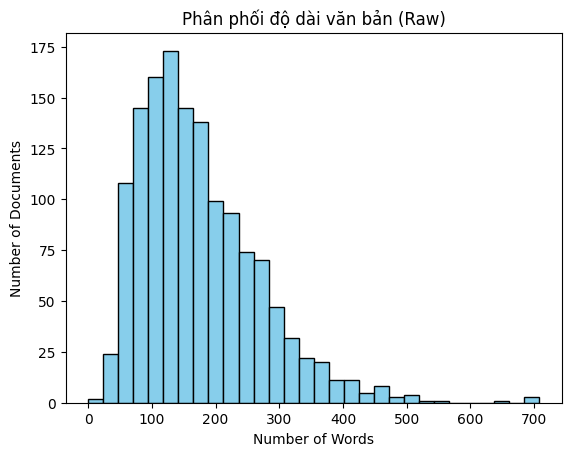

In [25]:
# Raw Document Length Distribution
raw_lengths = [len(word_tokenize(doc)) for doc in documents]
plt.hist(raw_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Phân phối độ dài văn bản (Raw)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

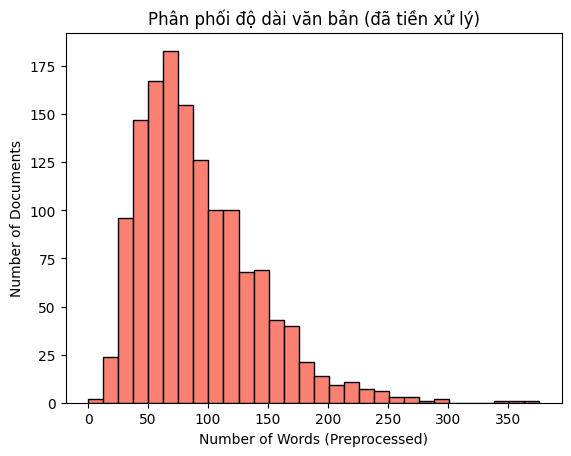

In [26]:
preprocessed_lengths = [len(d) for d in doc]
plt.hist(preprocessed_lengths, bins=30, color='salmon', edgecolor='black')
plt.title("Phân phối độ dài văn bản (đã tiền xử lý)")
plt.xlabel("Number of Words (Preprocessed)")
plt.ylabel("Number of Documents")
plt.show()

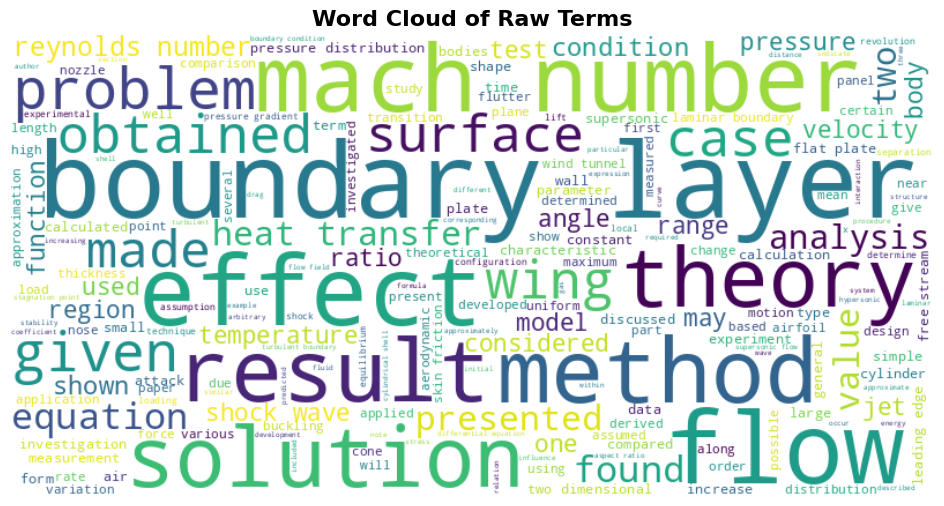

In [39]:
# 1. Word Cloud of Raw Terms
raw_text_all = " ".join(documents)
raw_tokens = word_tokenize(raw_text_all.lower())
raw_cleaned_tokens = [re.sub(r'[^a-z]', '', word) for word in raw_tokens if word.isalpha()]
raw_text_for_cloud = " ".join(raw_cleaned_tokens)

wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(raw_text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Raw Terms", fontweight='bold', fontsize=16)
plt.show()

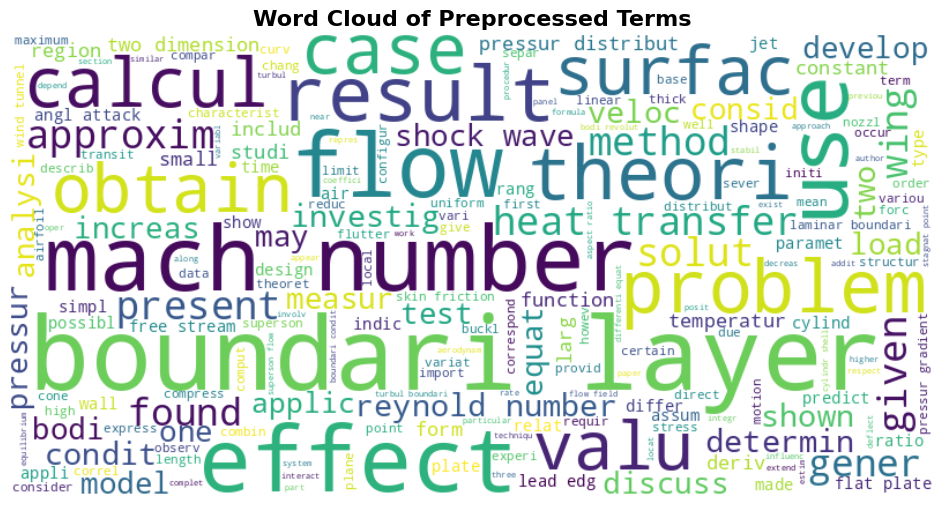

In [40]:
# 2. Word Cloud of Preprocessed Terms
preprocessed_all_tokens = [token for doc_tokens in doc for token in doc_tokens]
preprocessed_text_for_cloud = " ".join(preprocessed_all_tokens)

wordcloud_preprocessed = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_preprocessed, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Preprocessed Terms", fontweight='bold', fontsize=16)
plt.show()

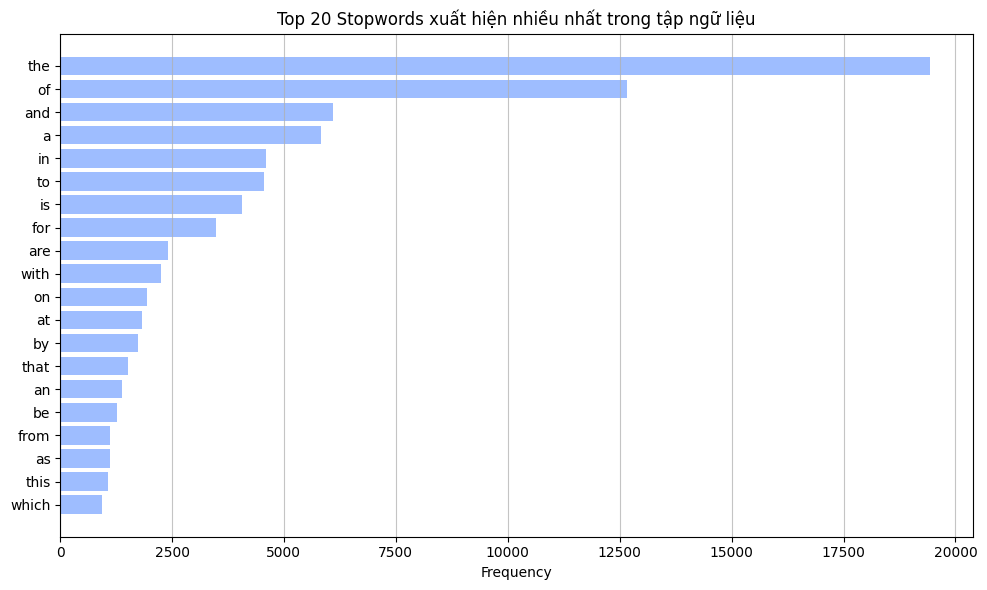

In [31]:
# stopwords
stopword_freq = Counter(token.lower() for doc in documents for token in doc.split() if token.lower() in stop_words)
top_stopwords = stopword_freq.most_common(20)

stopword_labels, counts = zip(*top_stopwords)

plt.figure(figsize=(10, 6))
plt.barh(stopword_labels, counts, color="#94B6FF", alpha=0.9)
plt.xlabel('Frequency')
plt.title('Top 20 Stopwords xuất hiện nhiều nhất trong tập ngữ liệu')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.show()

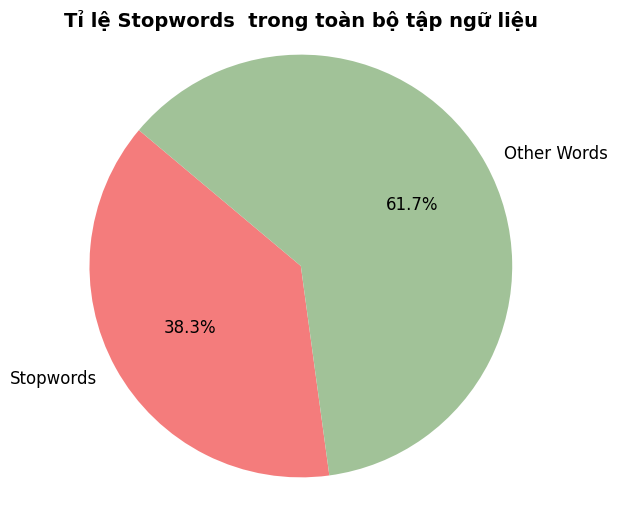

In [34]:
stop_words = set(stopwords.words("english"))

total_tokens = 0
total_stopwords = 0

for doc_text in documents:
    tokens = word_tokenize(doc_text.lower())
    total_tokens += len(tokens)
    total_stopwords += sum(1 for token in tokens if token in stop_words)

stopword_percentage = (total_stopwords / total_tokens) * 100
non_stopword_percentage = 100 - stopword_percentage

labels = ['Stopwords', 'Other Words']
sizes = [stopword_percentage, non_stopword_percentage]
colors = ['#F47C7C', '#A1C298']

plt.figure(figsize=(6, 6))
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140,
    colors=colors, textprops={'fontsize': 12}
)
plt.title('Tỉ lệ Stopwords  trong toàn bộ tập ngữ liệu', fontweight='bold', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

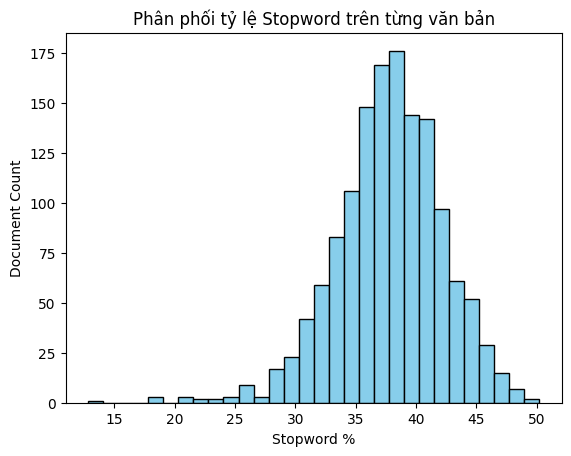

In [36]:
# Phân phối tỷ lệ Stopword trên từng văn bản
stopword_percentages = []
for doc_text in documents:
    tokens = word_tokenize(doc_text.lower())
    if not tokens:
        continue
    stop_count = sum(1 for word in tokens if word in stop_words)
    stopword_percentages.append((stop_count / len(tokens)) * 100)

plt.hist(stopword_percentages, bins=30, color='skyblue', edgecolor='black')
plt.title("Phân phối tỷ lệ Stopword trên từng văn bản")
plt.xlabel("Stopword %")
plt.ylabel("Document Count")
plt.show()


In [37]:
vocab_size = len(word_list)
avg_doc_length = np.mean([len(d) for d in doc])

print(f"Kích thước từ vựng (sau xử lý): {vocab_size}")
print(f"Độ dài trung bình mỗi văn bản (đã xử lý): {avg_doc_length:.2f}")

Kích thước từ vựng (sau xử lý): 4379
Độ dài trung bình mỗi văn bản (đã xử lý): 92.04
